# PM2.5 Forecast – Prediction Analysis

Notebook dùng để đọc file CSV kết quả dự báo, trực quan hóa sai số giữa `label` (thực tế) và `prediction`, đồng thời đối chiếu lại với dữ liệu gốc trên Iceberg.

In [17]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp
import warnings

warnings.filterwarnings('ignore')

sns.set_theme(style="darkgrid")
%matplotlib inline


In [19]:
# Read CSV from HDFS using subprocess (avoids SparkContext conflicts)
import subprocess
import io

hdfs_dir = "ml_outputs/pm25_predictions"
print(f"Reading predictions from HDFS: {hdfs_dir}")

try:
    # List files in HDFS directory
    list_result = subprocess.run(
        ["hdfs", "dfs", "-ls", hdfs_dir],
        capture_output=True,
        text=True,
        timeout=30,
        cwd="/home/dlhnhom2/dlh-aqi"
    )
    
    if list_result.returncode != 0:
        raise Exception(f"Failed to list HDFS: {list_result.stderr}")
    
    # Extract CSV files
    csv_files = []
    for line in list_result.stdout.split('\n'):
        if '.csv' in line and '_SUCCESS' not in line:
            parts = line.split()
            if len(parts) >= 8:
                csv_files.append(parts[-1])
    
    print(f"Found {len(csv_files)} CSV file(s)")
    
    # Read all CSV files
    dfs = []
    for csv_file in csv_files:
        print(f"  Reading: {csv_file}")
        result = subprocess.run(
            ["hdfs", "dfs", "-cat", csv_file],
            capture_output=True,
            text=True,
            timeout=60,
            cwd="/home/dlhnhom2/dlh-aqi"
        )
        
        if result.returncode == 0:
            df = pd.read_csv(io.StringIO(result.stdout))
            dfs.append(df)
            print(f"    Loaded {len(df)} records")
        else:
            raise Exception(f"Error reading {csv_file}: {result.stderr}")
    
    # Combine all dataframes
    pred_df = pd.concat(dfs, ignore_index=True)
    print(f"\nSuccessfully loaded {len(pred_df)} total records")
    
except Exception as e:
    print(f"Error: {e}")
    raise

# Process the dataframe
pred_df["ts_utc"] = pd.to_datetime(pred_df["ts_utc"])
pred_df.sort_values(["location_key", "ts_utc"], inplace=True)

# Add residual for later analysis
if "residual" not in pred_df.columns:
    pred_df["residual"] = pred_df["prediction"] - pred_df["label"]

print(f"\nData shape: {pred_df.shape}")
print(f"Columns: {list(pred_df.columns)}")
print("\nFirst few rows:")
pred_df.head()


Reading predictions from HDFS: ml_outputs/pm25_predictions
Found 1 CSV file(s)
  Reading: ml_outputs/pm25_predictions/part-00000-1066d201-8653-4e90-9b74-8d27959d43b0-c000.csv
Found 1 CSV file(s)
  Reading: ml_outputs/pm25_predictions/part-00000-1066d201-8653-4e90-9b74-8d27959d43b0-c000.csv
    Loaded 5148 records

Successfully loaded 5148 total records

Data shape: (5148, 18)
Columns: ['location_key', 'ts_utc', 'label', 'prediction', 'aod', 'co', 'co2', 'dust', 'no2', 'o3', 'pm10', 'so2', 'uv_index', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'residual']

First few rows:
    Loaded 5148 records

Successfully loaded 5148 total records

Data shape: (5148, 18)
Columns: ['location_key', 'ts_utc', 'label', 'prediction', 'aod', 'co', 'co2', 'dust', 'no2', 'o3', 'pm10', 'so2', 'uv_index', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'residual']

First few rows:


,location_key,ts_utc,label,prediction,aod,co,co2,dust,no2,o3,pm10,so2,uv_index,hour_sin,hour_cos,dow_sin,dow_cos,residual
3432,danang,2025-08-08 01:00:00+00:00,19.9,19.324657,0.13,628.0,503.0,0.0,11.6,138.0,21.600000,7.0,3.35,0.258819,0.965926,-0.781831,0.62349,-0.575342
3433,danang,2025-08-08 02:00:00+00:00,17.0,17.271291,0.13,552.0,484.0,0.0,8.3,191.0,18.500000,7.8,6.45,0.500000,0.866025,-0.781831,0.62349,0.271291
3434,danang,2025-08-08 03:00:00+00:00,13.4,18.753317,0.14,478.0,468.0,0.0,5.8,238.0,18.200001,8.3,9.40,0.707107,0.707107,-0.781831,0.62349,5.353317
3435,danang,2025-08-08 04:00:00+00:00,11.5,21.100423,0.15,409.0,460.0,0.0,4.7,273.0,19.400000,8.1,11.45,0.866025,0.500000,-0.781831,0.62349,9.600423
3436,danang,2025-08-08 05:00:00+00:00,11.6,15.949289,0.14,341.0,455.0,0.0,4.4,300.0,20.900000,7.5,11.95,0.965926,0.258819,-0.781831,0.62349,4.349288


## Tổng quan sai số

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_true = pred_df["label"].to_numpy()
y_pred = pred_df["prediction"].to_numpy()

# Calculate RMSE manually
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Calculate MAPE
mape = np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))) * 100.0

metrics = {
    "MAE": mean_absolute_error(y_true, y_pred),
    "RMSE": rmse,
    "R2": r2_score(y_true, y_pred),
    "MAPE (%)": mape,
}

print("Model Performance Metrics:")
for metric_name, metric_value in metrics.items():
    print(f"  {metric_name}: {metric_value:.4f}")

metrics


Model Performance Metrics:
  MAE: 9.0724
  RMSE: 15.0093
  R2: 0.6165
  MAPE (%): 35.5860


{'MAE': 9.072359850841176,
 'RMSE': 15.009306482681122,
 'R2': 0.6164806522606334,
 'MAPE (%)': 35.58599806493803}

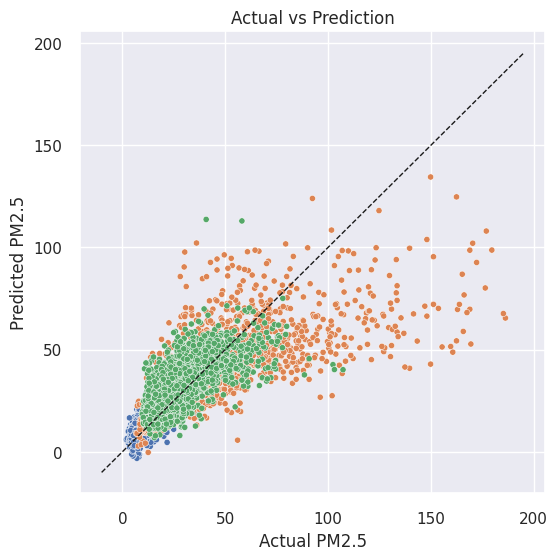

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=pred_df, x="label", y="prediction", hue="location_key", s=20, ax=ax, legend=False)
lims = [min(ax.get_xlim()[0], ax.get_ylim()[0]), max(ax.get_xlim()[1], ax.get_ylim()[1])]
ax.plot(lims, lims, "k--", linewidth=1)
ax.set_title("Actual vs Prediction")
ax.set_xlabel("Actual PM2.5")
ax.set_ylabel("Predicted PM2.5")
plt.show()


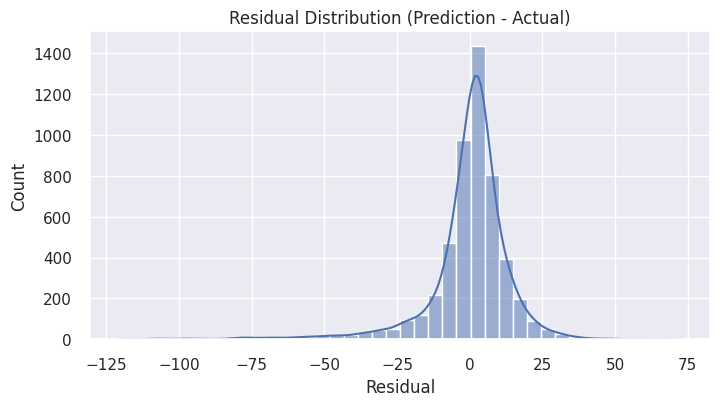

In [33]:
pred_df["residual"] = pred_df["prediction"] - pred_df["label"]
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(pred_df["residual"], bins=40, kde=True, ax=ax)
ax.set_title("Residual Distribution (Prediction - Actual)")
ax.set_xlabel("Residual")
plt.show()


### Diễn biến theo thời gian cho từng location


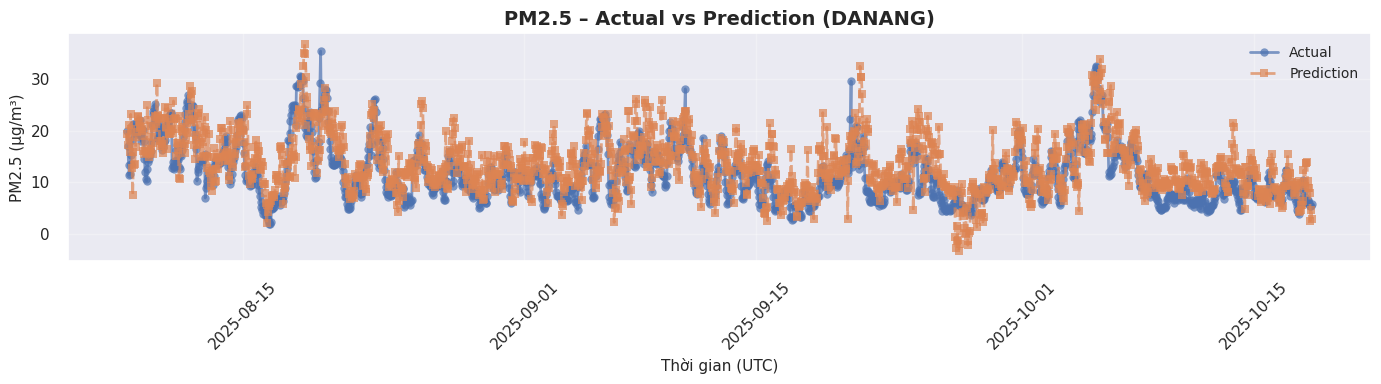

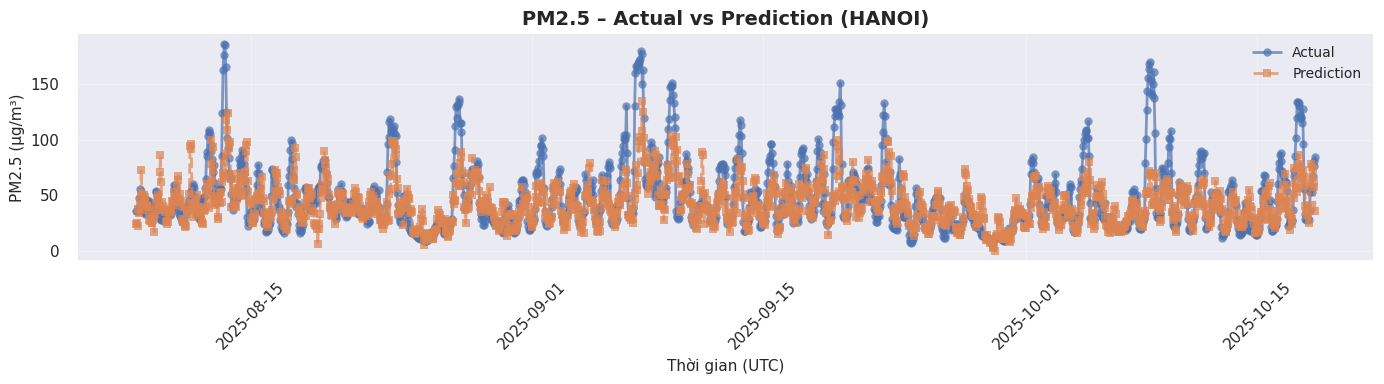

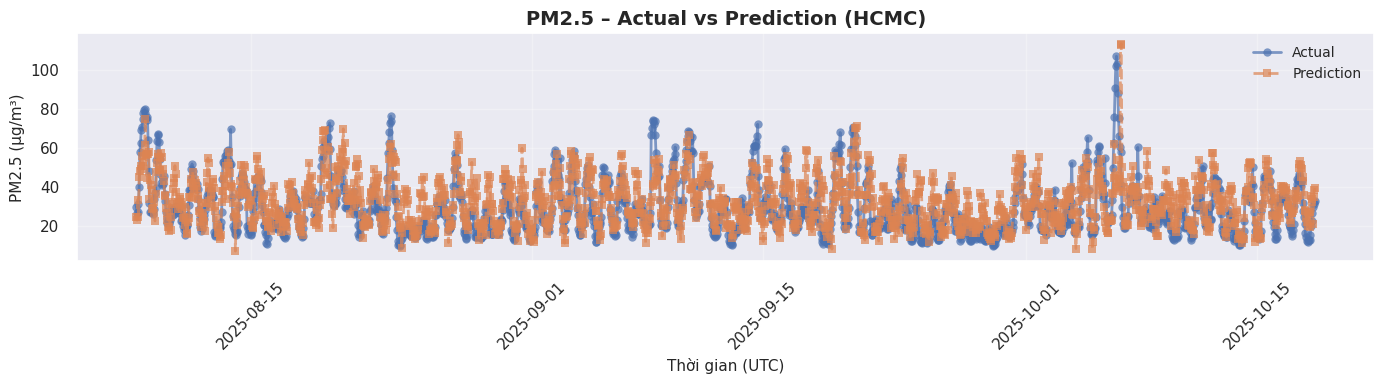

In [34]:
for location in sorted(pred_df['location_key'].unique()):
    loc_data = pred_df[pred_df['location_key'] == location].sort_values("ts_utc")
    
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(loc_data["ts_utc"], loc_data["label"], label="Actual", marker="o", linestyle="-", alpha=0.7, linewidth=2)
    ax.plot(loc_data["ts_utc"], loc_data["prediction"], label="Prediction", marker="s", linestyle="--", alpha=0.7, linewidth=2)
    
    ax.set_title(f"PM2.5 – Actual vs Prediction ({location.upper()})", fontsize=14, fontweight="bold")
    ax.set_xlabel("Thời gian (UTC)", fontsize=11)
    ax.set_ylabel("PM2.5 (µg/m³)", fontsize=11)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
